In [2]:
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from prince import MCA
from sklearn.cluster import KMeans
from scipy.stats import spearmanr
from plotnine import *


Importation de la base

In [3]:
url = "https://www.data.gouv.fr/api/1/datasets/r/aff9d702-db6d-46e5-8416-c032d8b9d89d"

response = requests.get(url)

if response.status_code == 200:
    with open("data_arcom.xlsx", "wb") as file:
        file.write(response.content)
    print("Téléchargement réussi !")
else:
    print("Erreur :", response.status_code)

df_brut = pd.read_excel("data_arcom.xlsx")
print(df_brut.head())
obs = df_brut.shape[0]
print(f"Nombre d'observations : {obs}")

Téléchargement réussi !
        SEXE  AGE       RAGE1        RAGE2        RAGE3          AGGLOIFOP0  \
0  Une femme   25  De25a34ans  De25a34ans1  De15a34ans2                UU05   
1   Un homme   64  De50a64ans  De50a64ans1    De50aPlus                UU02   
2  Une femme   35  De35a49ans  De35a49ans1  De35a49ans2  Hors unité urbaine   
3  Une femme   65  De65a74ans    De65aPlus    De50aPlus                UU06   
4   Un homme   40  De35a49ans  De35a49ans1  De35a49ans2                UU06   

  jz2cdep  jz2ctypcom  jz2ctailcom AGGLOIFOP0.1  ...  \
0      42           1            9         TUU5  ...   
1      44           3            3         TUU2  ...   
2      70           6            1         TUU0  ...   
3      64           1           10         TUU6  ...   
4      30           1           11         TUU6  ...   

                                            RS18_r12  \
0                                                NaN   
1                                                NaN

On a 831 variables dans le dataset, pour 5002 observations.



Sélection et recodage des variables

In [4]:
variables = [
    "SEXE", "AGE", "AGGLOIFOP2", "TYPCOM", "TAILCOM", "DPT", "REG3", "REG13",
    "SITI", "PPIA", "RECPPIA", "STCA", "STATUT", "FOYER",
    # Q1 quel produit avez-vous consommé de manière dématérialisée ces 12 derniers mois ?
    "Q1_1", "Q1_2", "Q1_3", "Q1_4", "Q1_5", "Q1_6", "Q1_7", "Q1_8", "Q1_9", "Q1_10", "Q1_11",
    # Q2 : à quelle fréquence ?
    "Q2_r1", "Q2_r2", "Q2_r3", "Q2_r4", "Q2_r5", "Q2_r6", "Q2_r7", "Q2_r8", "Q2_r9", "Q2_r10", "Q2_r11",
    # Q2BIS : regardez-vous des vidéos de courtes durée proposées par Youtube?
    "Q2BIS",
    # Q3 : consommation légale ? (globalité)
    "Q3",
    # Q4 : consommation légale ? globalité dans le cadre des activités proposées question1
    "Q4",
    # Q5_r : consommation légale pour chaque activité
    "Q5_r1", "Q5_r2", "Q5_r3", "Q5_r4", "Q5_r5", "Q5_r6", "Q5_r7", "Q5_r8", "Q5_r9", "Q5_r10",
    "Q5_r11",
    # Q6 : fréquence de conso illégale
    "Q6_r1", "Q6_r2", "Q6_r3", "Q6_r4", "Q6_r5", "Q6_r6", "Q6_r7", "Q6_r8", "Q6_r9", "Q6_r10",
    "Q6_r11",
    # QBOL14 : comment découvrez-vous de nouveaux films ?
    "QBOL14_1", "QBOL14_2", "QBOL14_3", "QBOL14_4", "QBOL14_5", "QBOL14_6", "QBOL14_7", "QBOL14_8",
    "QBOL14_9",
    # QBU1 : consommation payante ou gratuite ?
    "QBU1_r1", "QBU1_r2", "QBU1_r3", "QBU1_r4", "QBU1_r5", "QBU1_r6", "QBU1_r7", "QBU1_r8",
    "QBU1_r9", "QBU1_r10", "QBU1_r11",
    # QBU7 : 3 principales raisons de ne pas consommer légalement
    "QBU7_r1_c1", "QBU7_r2_c1", "QBU7_r3_c1", "QBU7_r4_c1", "QBU7_r5_c1", "QBU7_r6_c1", "QBU7_r7_c1",
    "QBU7_r8_c1", "QBU7_r9_c1", "QBU7_r10_c1", "QBU7_r11_c1", "QBU7_r12_c1", "QBU7_r13_c1",
    "QBU7_r14_c1", "QBU7_r15_c1", "QBU7_r16_c1",
    # RS14 : quel service avez vous accès pour écouter de la musique
    "RS14_1", "RS14_2", "RS14_3", "RS14_4", "RS14_5", "RS14_6", "RS14_7", "RS14_8", "RS14_9",
    "POIDS"
]

pratiques = ["mus","films","series","photos","jv","livres","logi","presse","retrans","autres"]

df_cleaned = df_brut[variables]

df_cleaned.replace({"#NUL!": np.nan, "": np.nan, " ": np.nan}, inplace=True)

# On retire les espaces au début et à la fin des string pour le recodage au cas où
df_cleaned = df_cleaned.applymap(lambda x: x.strip() if isinstance(x, str) else x)


df = pd.DataFrame([])

# Recodage des variables
sexe_map = {"Une femme": 0, "Un homme": 1}
df["sexe"] = df_cleaned["SEXE"].map(sexe_map)

df["age"] = df_cleaned["AGE"]

agglo_map = {"MoinsDe100000Habitants": 0, "PlusDe100000Habitants": 1}
df["plusde10000habitants"] = df_cleaned["AGGLOIFOP2"].map(agglo_map)

df["type_commune"] = df_cleaned["TYPCOM"]

df["taille_commune"] = df_cleaned["TAILCOM"]

df["departement"] = df_cleaned["DPT"]

province_map = {"RegionIleDeFrance": 0, "PROVINCE": 1}
df["province"] = df_cleaned["REG3"].map(province_map)

df["region"] = df_cleaned["REG13"]

df["situation_actuelle"] = df_cleaned["SITI"]

df["profession"] = df_cleaned["PPIA"]

df["csp"] = df_cleaned["RECPPIA"]

df["statut"] = df_cleaned["STATUT"]

df["foyer"] = df_cleaned["FOYER"]

df[["conso_demat_mus", "conso_demat_films", "conso_demat_series", "conso_demat_photos", "conso_demat_jv", "conso_demat_livres", "conso_demat_logi", "conso_demat_presse", "conso_demat_retrans", "conso_demat_autres"]] = df_cleaned[["Q1_1", "Q1_2", "Q1_3", "Q1_4", "Q1_5", "Q1_6", "Q1_7", "Q1_8", "Q1_9", "Q1_10"]]

freq_map = {"Moins souvent": "Rare", "1 à 3 fois par mois": "Occasionnel", "1 à 5 fois par semaine": "Regulier", "Tous les jours ou presque": "Intensif"}
df[["freq_demat_mus", "freq_demat_films", "freq_demat_series", "freq_demat_photos", "freq_demat_jv", "freq_demat_livres", "freq_demat_logi", "freq_demat_presse", "freq_demat_retrans", "freq_demat_autres"]] = df_cleaned[["Q2_r1", "Q2_r2", "Q2_r3", "Q2_r4", "Q2_r5", "Q2_r6", "Q2_r7", "Q2_r8", "Q2_r9", "Q2_r10"]]

for p in pratiques:
    df[f"freq_demat_{p}"] = df[f"freq_demat_{p}"].map(freq_map)

legal_map = {"Exclusivement de façon légale": 1, "Exclusivement de façon illégale": 0, "Les deux, légalement et illégalement": 0.5}
df["legal"] = df_cleaned["Q3"].map(legal_map)

df["legal_culture"] = df_cleaned["Q4"]

df["poids"] = df_cleaned["POIDS"]

print(df.head())

   sexe  age  plusde10000habitants      type_commune     taille_commune  \
0     0   25                     0       VilleCentre   De30000a49999hab   
1     1   64                     0  BanlieueNVInterm     De2000a3499hab   
2     0   35                     0             Rural     Moinsde1000hab   
3     0   65                     1       VilleCentre   De50000a99999hab   
4     1   40                     1       VilleCentre  De100000habEtPlus   

            departement  province                 region  \
0                 LOIRE         1     AuvergneRhoneAlpes   
1       LOIREATLANTIQUE         1         PaysDeLaLoire1   
2            HAUTESAONE         1  BourgogneFrancheComte   
3  PYRENNEESATLANTIQUES         1     NouvelleAquitaine1   
4                  GARD         1             Occitanie1   

                                  situation_actuelle  \
0  Vous exercez une activité professionnelle (act...   
1  Vous exercez une activité professionnelle (act...   
2  Vous exercez une 

/tmp/ipykernel_211044/1806930779.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_211044/1806930779.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.





Vérification des données manquantes



In [5]:
print("\nValeurs manquantes par colonne :")
print(df.isna().sum().to_string())

print("\nPourcentage de valeurs manquantes :")
print((df.isna().mean() * 100).to_string())



Valeurs manquantes par colonne :
sexe                       0
age                        0
plusde10000habitants       0
type_commune               0
taille_commune             0
departement                0
province                   0
region                     0
situation_actuelle         0
profession               868
csp                        0
statut                     0
foyer                      0
conso_demat_mus            0
conso_demat_films          0
conso_demat_series         0
conso_demat_photos         0
conso_demat_jv             0
conso_demat_livres         0
conso_demat_logi           0
conso_demat_presse         0
conso_demat_retrans        0
conso_demat_autres         0
freq_demat_mus          2410
freq_demat_films        2413
freq_demat_series       2652
freq_demat_photos       3043
freq_demat_jv           3158
freq_demat_livres       3718
freq_demat_logi         3737
freq_demat_presse       3170
freq_demat_retrans      4135
freq_demat_autres       5002
legal    

Statistiques descriptives

In [6]:
for i in range(1, 10):
    col = f"QBOL14_{i}"
    print(f"\n{col}")
    print(df_cleaned[col].unique())



QBOL14_1
[nan 0
 'Sur des plateformes de vidéos à la demande (SVOD) comme Netflix, Amazon Prime, Disney+…']

QBOL14_2
[nan 0 'Sur des plateformes de partage de vidéos (YouTube, Dailymotion…)']

QBOL14_3
[nan 'Sur les réseaux sociaux (Instagram, Facebook, Snapchat…)' 0]

QBOL14_4
[nan 0
 'Via la télévision ou la radio (informations générales ou émissions spécialisées…)']

QBOL14_5
[nan 0 'Via la presse ou des sites spécialisés sur l’actualité du cinéma']

QBOL14_6
[nan 'Lors de discussions avec mes amis/proches' 0]

QBOL14_7
[nan
 'Via de la publicité vue à la télévision, sur Internet, en affichage…' 0]

QBOL14_8
[nan 0
 'Dans les rayons films des médiathèques, des magasins physiques (Fnac, etc.)']

QBOL14_9
[nan 0 'Par d’autres moyens de découverte, préciser:']


In [7]:
print("\n--- Variables numériques ---")
print(df.describe(include="number").T)

print("\n--- Variables catégorielles ---")
categorical_cols = df.select_dtypes(include="object").columns.tolist()
for col in categorical_cols:
    print(f"\nVariable : {col}")
    counts = df[col].value_counts(dropna=False)
    percentages = df[col].value_counts(normalize=True, dropna=False) * 100
    print(pd.concat([counts, percentages], axis=1, keys=["count", "percent"]))



--- Variables numériques ---
                       count       mean        std        min        25%  \
sexe                  5002.0   0.479808   0.499642   0.000000   0.000000   
age                   5002.0  45.205518  17.509050  15.000000  30.000000   
plusde10000habitants  5002.0   0.517393   0.499747   0.000000   0.000000   
province              5002.0   0.802679   0.398017   0.000000   1.000000   
legal                    0.0        NaN        NaN        NaN        NaN   
poids                 5002.0   1.000000   0.324890   0.163347   0.799224   

                            50%        75%         max  
sexe                   0.000000   1.000000    1.000000  
age                   46.000000  60.000000  120.000000  
plusde10000habitants   1.000000   1.000000    1.000000  
province               1.000000   1.000000    1.000000  
legal                       NaN        NaN         NaN  
poids                  0.937118   1.107638    3.499173  

--- Variables catégorielles ---

Vari

In [8]:
def weighted_freq(series, weights):
    return (series
            .groupby(series)
            .apply(lambda x: weights.loc[x.index].sum())
            / weights.sum()) * 100

print("\n--- Fréquences pondérées des pratiques ---")
for p in pratiques:
    print(f"\n{p}")
    print(weighted_freq(df[f"conso_demat_{p}"], df["poids"]))


--- Fréquences pondérées des pratiques ---

mus
conso_demat_mus
0                         50.000002
Musique / Vidéos clips    49.999998
Name: conso_demat_mus, dtype: float64

films
conso_demat_films
0        49.000005
Films    50.999995
Name: conso_demat_films, dtype: float64

series
conso_demat_series
0            54.000002
Séries TV    45.999998
Name: conso_demat_series, dtype: float64

photos
conso_demat_photos
0         62.000003
Photos    37.999997
Name: conso_demat_photos, dtype: float64

jv
conso_demat_jv
0             64.000001
Jeux vidéo    35.999999
Name: conso_demat_jv, dtype: float64

livres
conso_demat_livres
0         75.000001
Livres    24.999999
Name: conso_demat_livres, dtype: float64

logi
conso_demat_logi
0            75.000001
Logiciels    24.999999
Name: conso_demat_logi, dtype: float64

presse
conso_demat_presse
0         65.0
Presse    35.0
Name: conso_demat_presse, dtype: float64

retrans
conso_demat_retrans
0                                      83.0
Retransmi

In [9]:
# Tableaux croisés pondérés (ex : sexe × musique)
ct = pd.pivot_table(
    df,
    values="poids",
    index="csp",
    columns="conso_demat_livres",
    aggfunc="sum",
)/5002 * 100

print("\nTableau croisé pondéré sexe × musique (%)")
print(ct)


Tableau croisé pondéré sexe × musique (%)
conso_demat_livres              0    Livres
csp                                        
Agriculteurs1            0.759776  0.240224
Artisans1                2.648473  1.351527
Autres1                  5.535257  1.225788
Cadres1                  5.693274  4.306725
ElevesEtudiantsPemploi   7.453995  3.784960
Employes1               12.693537  4.306463
Intermediaires1         10.378193  3.621807
Ouvriers1               10.776113  2.223888
RetraitesCSPMoins        6.743708  0.965326
RetraitesCSPPlus        12.317675  2.973292


variables binaires de pratiques et acm

In [10]:
pratiques = [
    "conso_demat_mus", "conso_demat_films", "conso_demat_series",
    "conso_demat_photos", "conso_demat_jv", "conso_demat_livres",
    "conso_demat_logi", "conso_demat_presse", "conso_demat_retrans",
    "conso_demat_autres"
]

for col in pratiques:
    df[col + "_bin"] = np.where(df[col].notna() & (df[col] != 0), "Oui", "Non")


# Variables de pratiques uniquement
acm_vars = [c for c in df.columns if c.endswith("_bin") or c.startswith("freq_")]
print("Variables actives ACM :", acm_vars)
print(df[acm_vars].head())

mca = MCA(random_state=42)

mca_fit = mca.fit(df[acm_vars])




Variables actives ACM : ['freq_demat_mus', 'freq_demat_films', 'freq_demat_series', 'freq_demat_photos', 'freq_demat_jv', 'freq_demat_livres', 'freq_demat_logi', 'freq_demat_presse', 'freq_demat_retrans', 'freq_demat_autres', 'conso_demat_mus_bin', 'conso_demat_films_bin', 'conso_demat_series_bin', 'conso_demat_photos_bin', 'conso_demat_jv_bin', 'conso_demat_livres_bin', 'conso_demat_logi_bin', 'conso_demat_presse_bin', 'conso_demat_retrans_bin', 'conso_demat_autres_bin']
  freq_demat_mus freq_demat_films freq_demat_series freq_demat_photos  \
0            NaN              NaN               NaN               NaN   
1            NaN              NaN               NaN          Regulier   
2       Intensif         Intensif          Intensif          Regulier   
3            NaN              NaN               NaN               NaN   
4       Intensif      Occasionnel       Occasionnel               NaN   

  freq_demat_jv freq_demat_livres freq_demat_logi freq_demat_presse  \
0           N

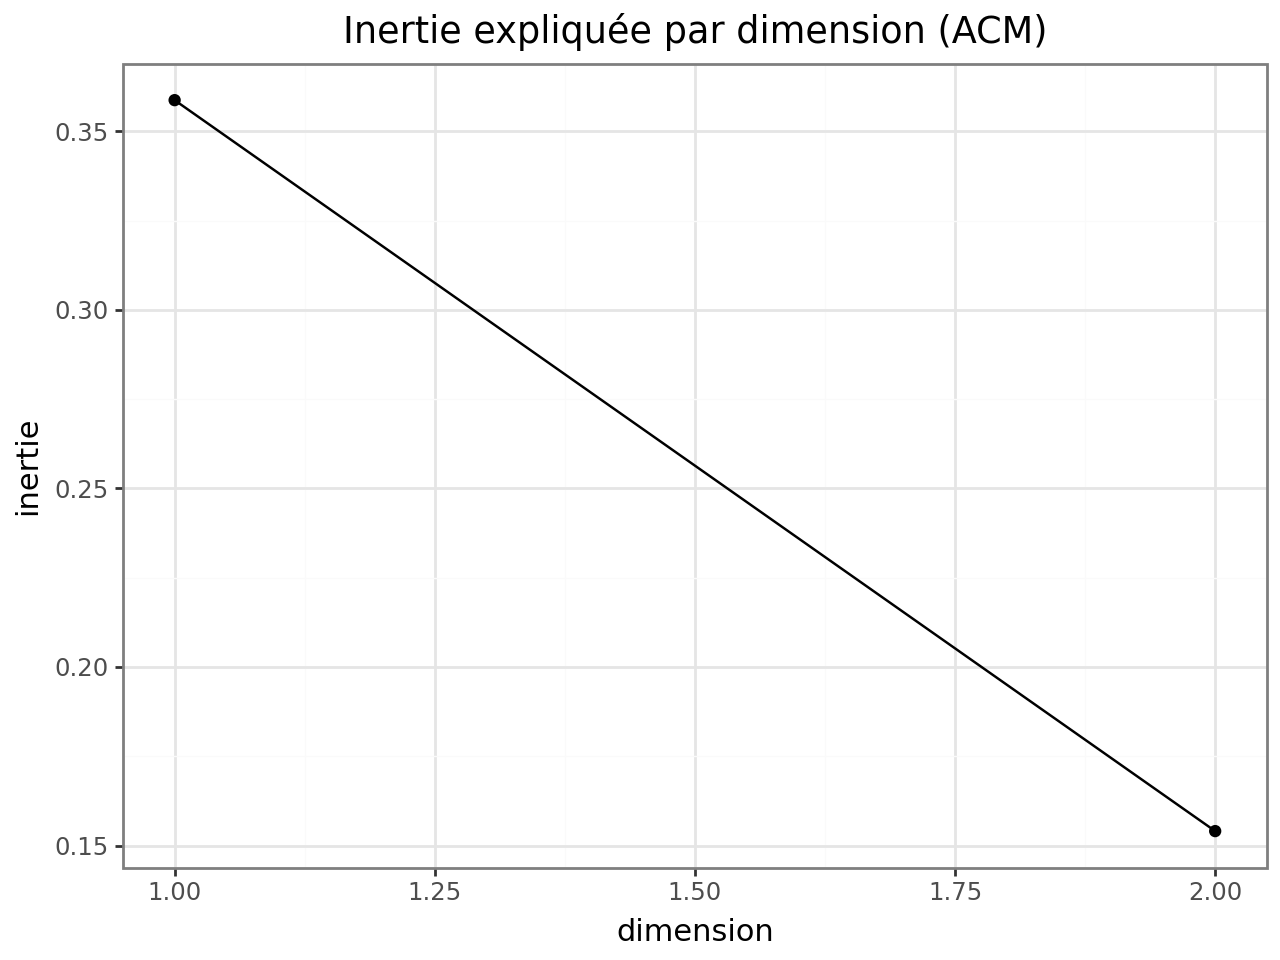

In [11]:
# Inertie expliquée
eig = mca_fit.eigenvalues_
inertia_df = pd.DataFrame({
    "dimension": range(1, len(eig) + 1),
    "inertie": eig,
    "inertie_cumulee": np.cumsum(eig)
})

p_inertia = (
    ggplot(inertia_df, aes(x="dimension", y="inertie")) +
    geom_line() + geom_point() +
    theme_bw() +
    labs(title="Inertie expliquée par dimension (ACM)")
)

p_inertia

In [12]:
contrib = mca.column_contributions_

contrib_12 = contrib.iloc[:, :2]
contrib_12.columns = ["Dim1", "Dim2"]

print("\nTop contributions – Dimension 1")
print(contrib_12["Dim1"].sort_values(ascending=False).head(15))

print("\nTop contributions – Dimension 2")
print(contrib_12["Dim2"].sort_values(ascending=False).head(15))




Top contributions – Dimension 1
conso_demat_films_bin__Non      0.089590
conso_demat_series_bin__Non     0.077928
conso_demat_mus_bin__Non        0.073967
conso_demat_jv_bin__Non         0.058332
conso_demat_photos_bin__Non     0.055174
conso_demat_logi_bin__Non       0.040507
conso_demat_livres_bin__Non     0.036997
conso_demat_presse_bin__Non     0.033583
conso_demat_logi_bin__Oui       0.031238
conso_demat_jv_bin__Oui         0.030955
conso_demat_series_bin__Oui     0.029730
conso_demat_retrans_bin__Non    0.029361
conso_demat_films_bin__Oui      0.029140
conso_demat_retrans_bin__Oui    0.028850
freq_demat_mus__Intensif        0.026721
Name: Dim1, dtype: float64

Top contributions – Dimension 2
freq_demat_films__Intensif       0.090120
freq_demat_jv__Intensif          0.069392
freq_demat_series__Intensif      0.066494
conso_demat_presse_bin__Oui      0.045078
freq_demat_livres__Intensif      0.042486
freq_demat_retrans__Intensif     0.041784
freq_demat_films__Occasionnel    0.03934

L'axe 1 est marqué par l'opposition entre consommation et non-consommation de biens culturels dématérialisés. C'est un axe d’intensité et de diversification de la consommation numérique.

L'axe 2 distingue les usages intensifs des usages plus occasionnels ou rares, c'est donc un axe de voracité de la consommation de ces biens.


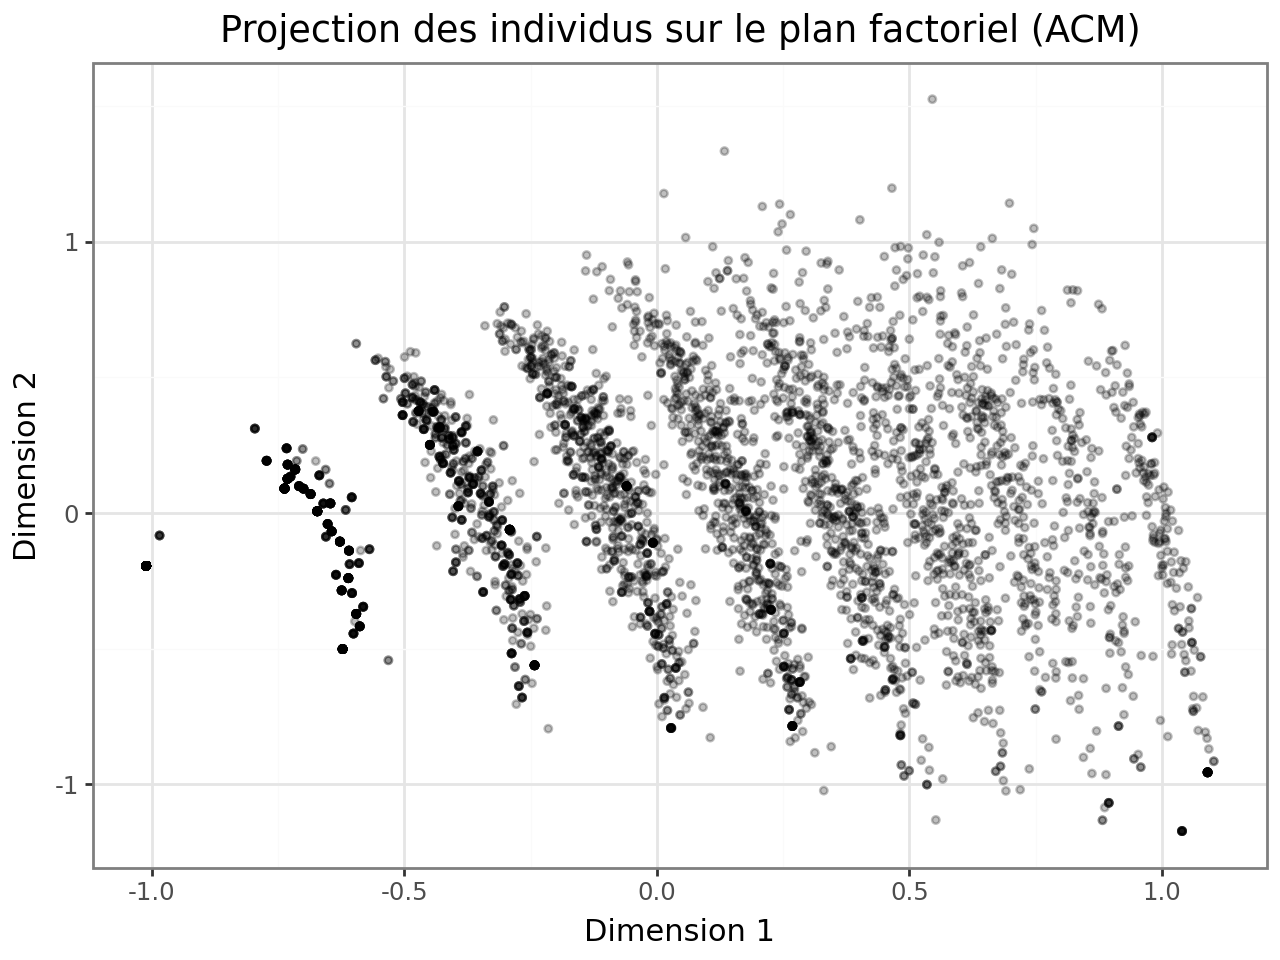

In [13]:
# Coordonnées individuelles
coords = mca_fit.transform(df[acm_vars])

ind = coords.iloc[:, :2].copy()
ind.columns = ["Dim1", "Dim2"]


p_ind = (
    ggplot(ind, aes(x="Dim1", y="Dim2")) +
    geom_point(alpha=0.25, size=1) +
    theme_bw() +
    labs(
        title="Projection des individus sur le plan factoriel (ACM)",
        x="Dimension 1",
        y="Dimension 2"
    )
)

p_ind



les individus se répartissent par strates qui correspondent à un engagement proressif dans la consommation de biens culturels dématérialisés.


clustering


3 clusters
1    0.42
2    0.32
0    0.26
Name: proportion, dtype: float64

4 clusters
1    0.31
3    0.31
0    0.21
2    0.18
Name: proportion, dtype: float64

5 clusters
4    0.29
3    0.21
2    0.18
1    0.17
0    0.15
Name: proportion, dtype: float64
   k      inertia
0  2  1188.940440
1  3   775.007581
2  4   571.376500
3  5   448.230642
4  6   377.450081
5  7   334.342534
6  8   285.257706


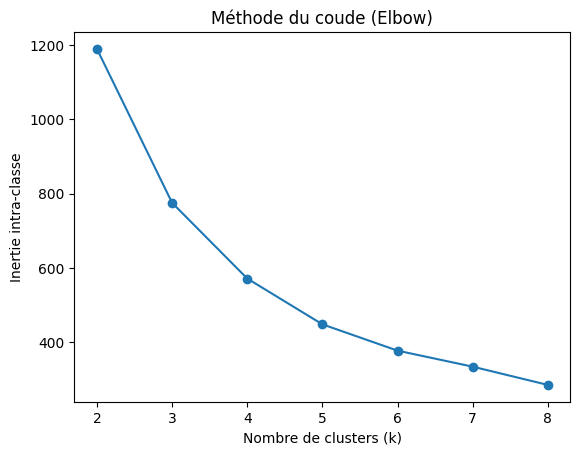

In [14]:

X = coords.iloc[:, :2]  # Dim 1 et Dim 2 uniquement

inertia = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertia.append(km.inertia_)
    if k in [3,4,5]:
        labels = km.fit_predict(X)
        print(f"\n{k} clusters")
        print(pd.Series(labels).value_counts(normalize=True).round(2))


elbow_df = pd.DataFrame({"k": K, "inertia": inertia})
print(elbow_df)


plt.figure()
plt.plot(elbow_df["k"], elbow_df["inertia"], marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-classe")
plt.title("Méthode du coude (Elbow)")
plt.show()




Avec la méthode du code, on choisira 4 clusters.

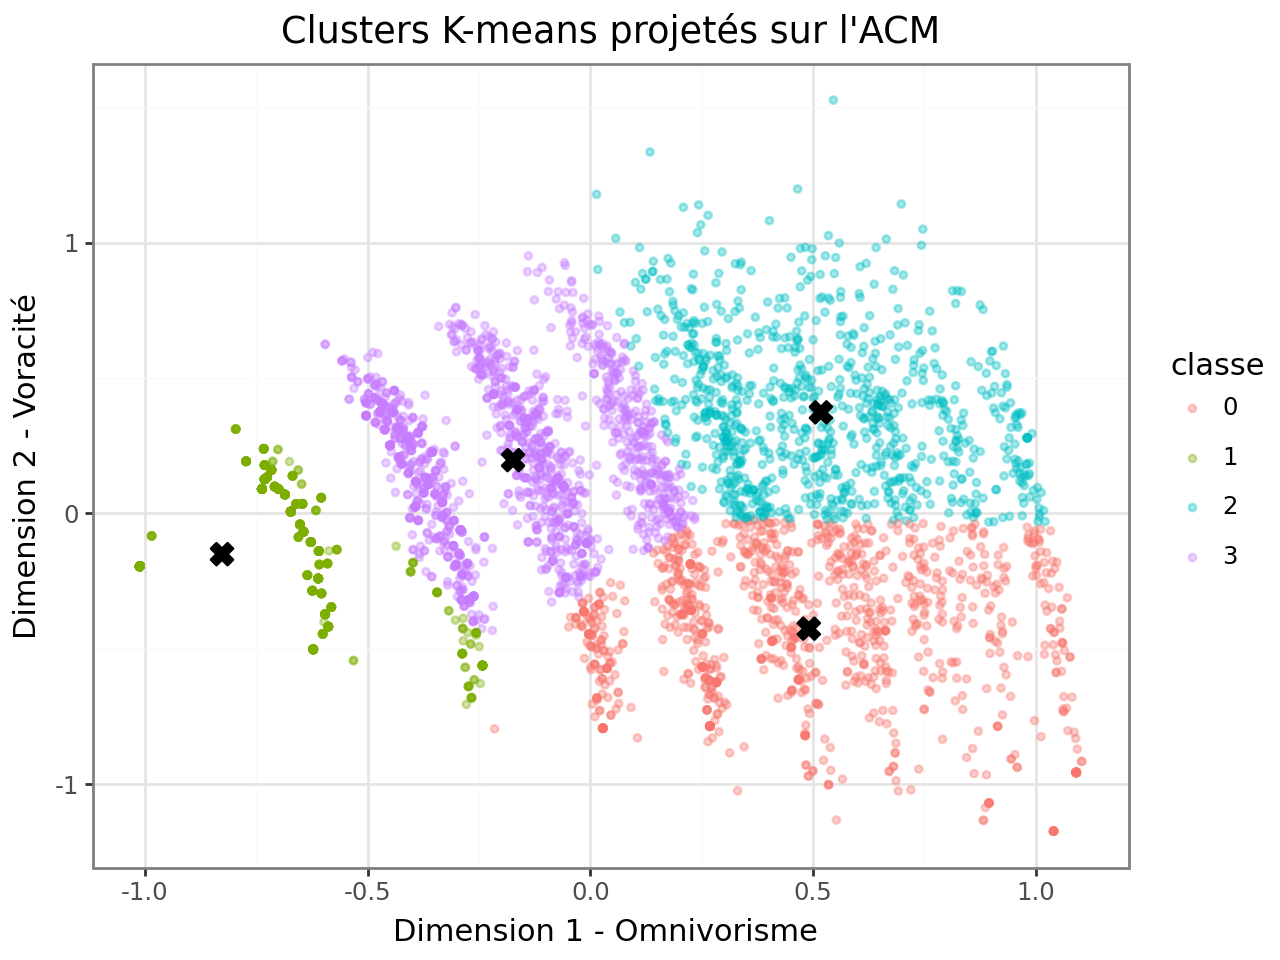

In [17]:
X = coords.iloc[:, :2].copy()
X.columns = ["Dim_1", "Dim_2"]

kmeans = KMeans(n_clusters=4, random_state=42)
df["classe"] = kmeans.fit_predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids["classe"] = centroids.index.astype("category")

plot_df = X.copy()
plot_df["classe"] = df["classe"].astype("category")

p = (
    ggplot(plot_df, aes("Dim_1", "Dim_2", color="classe")) +
    geom_point(alpha=0.35, size=1) +
    geom_point(data=centroids, mapping=aes("Dim_1", "Dim_2"),
               color="black", size=4, shape="X") +
    theme_bw() +
    labs(title="Clusters K-means projetés sur l'ACM",
         x="Dimension 1 - Omnivorisme ", y="Dimension 2 - Voracité")
)

p

Nous allons décrire les clusters et leurs caractéristiques socio-économiques. 


Profilage pondéré de la CSP par cluster 

Il s'agit ici de repérer les cluster où les classes supérieures sont plus ou sur-représentées. Pour l'étape de profilage, nous avons utilisé les pondérations individuelles de l'enquête, afin de corriger les déséquilibres de l'échantillon et garantir la représentativité de nos résultats. 

In [ ]:
def profil_categoriel(df, var):
    tab = pd.pivot_table(
        df,
        values="poids",
        index="classe",
        columns=var,
        aggfunc="sum",
        fill_value=0
    )
    return tab.div(tab.sum(axis=1), axis=0) * 100

profil_csp = profil_categoriel(df, "csp")
profil_csp.round(1)


csp,Agriculteurs1,Artisans1,Autres1,Cadres1,ElevesEtudiantsPemploi,Employes1,Intermediaires1,Ouvriers1,RetraitesCSPMoins,RetraitesCSPPlus
classe,,,,,,,,,,
0,1.2,6.9,4.2,15.6,22.9,16.7,11.9,14.7,2.6,3.2
1,1.3,2.5,9.8,4.6,4.6,17.9,12.4,13.6,13.3,20.0
2,0.7,4.3,4.3,15.9,14.3,14.6,18.6,10.2,2.9,14.3
3,0.7,3.4,6.7,8.6,8.7,17.6,14.5,12.8,8.0,19.0


Le cluster 0 se caractérise par un omnivorisme marqué et une consommation occasionnelle. Les cadres comptent 15.6% des personnes de cette classe, les employés et ouvriers composent 31.4% de la classe. C'est une classe plutôt générale, sans être populaire ou élitiste.

Le cluster 1, les faibles consommateurs, regroupe principalement des retraités (33.3%), et des ouvriers et employés (31.5%). Le profil des faibles consommateurs est très éloigné des classes supérieures actives (4.6% de cadres, il s'agit de la plus faible proportion parmi les 4 clusters).

Le cluster 2, avec un profil omnivore et vorace, compte 15.9% de cadres et 18.6% de personnes exerçant des professions intermédiaires, ce qui en fait le cluster avec la plus grande proportion de ces deux catégories. En cumulant cadres actifs et retraités de classe supérieure, on arrive alors à 30.2% du cluster représenté (48.8% en ajoutant les professions intermédiaires). 

Le cluster 3, regroupant les utilisateurs ayant une consommation sélective et régulière (omnivorisme sélectif mais non vorace), est composé d'individus plus diplômés (19% de retraités de classe supérieure, 8.6% de cadres et 14.5% de personnes exerçant des professions intermédiaires), mais aussi plus âgé (27% de retraités).

L'hypothèse de départ, selon laquelle les classes supérieures seraient plus omnivores et voraces semble ici être vérifiée de manière descriptive. 
Nous allons maintenant tester cette hypothèse avec des régressions. 

Régressions logistiques 

Nous cherchons maintenant à comparer les profils issus du clustering. Pour cela nous allons procéder à des régressions. Notre variable dépendante (le fait d'appartenir au cluster i ou non) étant binaire, nous avons recours à des régressions logistiques, formulées dans le cadre des régressions linéaires généralisées. Ces modèles nous permettront d'obtenir des probabilités prédites comprises entre 0 et 1 et des hypothèses statistiques adaptées à nos données.

Afin d’identifier les facteurs associés à l’appartenance aux différents profils de consommation, nos régressions incluent plusieurs variables explicatives exprimant les caractéristiques sociodémographiques et territoriales des individus. 
Nous avons saisie la position sociale des individus par leur catégorie socioprofessionnelle, en distinguant les classes supérieures actives. Nous avons fait le choix de ne pas inclure les retraités de classe supérieures, car ils ont des pratiques marquées par leur âge (faible consommation dématérialisée), et peuvent donc flouter nos interprétations entre les liens du capital culturel et ressources actives.
Nous contrôlons l’âge et le sexe et incluons des variables géographiques, telle que l’appartenance à une grande aire urbaine (plus ou moins de 100 000 habitants). Nous avons obtenu les estimations à partir de données pondérées, pour les mêmes raisons citées que celles du profilage pondéré des clusters. 